#Project In Progress
___

# Some installations

In [ ]:
!pip -q install tensorboardX

ERROR: Invalid requirement: 'tensorboardX#': Expected end or semicolon (after name and no valid version specifier)
    tensorboardX#
                ^


In [33]:
!pip -q install ale-py

In [34]:
!pip -q install "gymnasium[atari,accept-rom-license,other]" ale-py

In [25]:
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import random
from collections import namedtuple,deque




# Let's Start The Project

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [27]:
gym.register_envs(ale_py)

In [28]:
env=gym.make("ALE/SpaceInvaders-v5")

In [29]:
image_of_game=env.reset(seed=41)

In [30]:
frame_dim=image_of_game[0].shape
print(f'The Frame Dimensions Are:{frame_dim}')

The Frame Dimensions Are:(210, 160, 3)


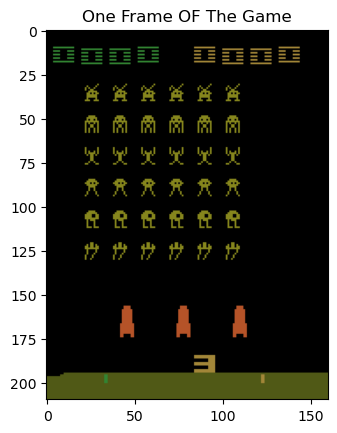

In [31]:
plt.title('One Frame OF The Game')
plt.imshow(image_of_game[0])

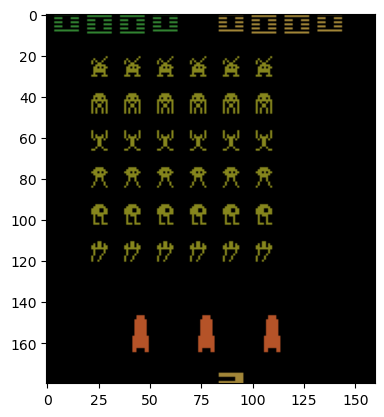

In [32]:
plt.imshow(image_of_game[0][10:190])

In [33]:
num_actions = env.action_space.n
print(f"Number of actions: {num_actions}")

Number of actions: 6



* 0=> NOOP,
* 1=> FIRE,
* 2=> RIGHT,
* 3=> LEFT,
* 4=> RIGHTFIRE,
* 5=> LEFTFIRE

In [34]:
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

In [35]:
new_image=env.step(1)

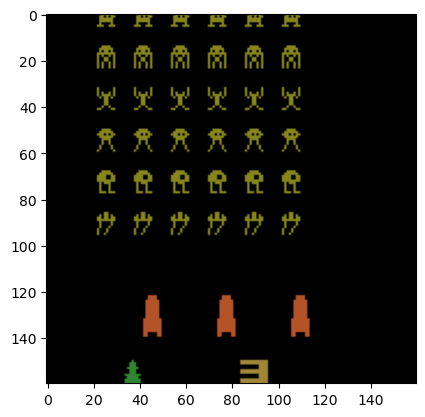

In [36]:
plt.imshow(new_image[0][35:195])


# Make Frames 80x80 float array

In [ ]:
# Preprocessing remains mostly the same
def prepro(I):
    """Preprocess 210x160x3 uint8 frame into 80x80 float array"""
    I = I[35:195]           # crop
    I = I[::2, ::2, 0]      # downsample by factor of 2
    I[I == 144] = 0         # erase background (background type 1)
    I[I == 109] = 0         # erase background (background type 2)
    I[I != 0] = 1           # everything else (paddles, ball) set to 1
    return I.astype(np.float32)


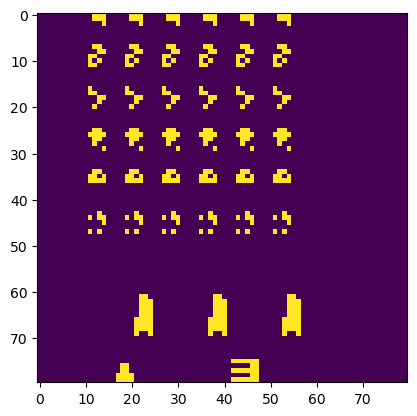

In [38]:
prepro_frame=prepro(new_image[0])
plt.imshow(prepro_frame)
#This is what my model will see

In [ ]:
class DQNet(nn.Module):
    def __init__(self, action_size):
        super(DQNet, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(64)

        # Compute conv output dynamically
        def _get_conv_output(shape):
            o = self.conv1(torch.zeros(1, *shape))
            o = self.conv2(o)
            o = self.conv3(o)
            return int(np.prod(o.size()))

        conv_out_size = _get_conv_output((4, 80, 80))
        self.head = nn.Linear(conv_out_size, action_size)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        return self.head(x)


DQNet class redefined with 4 input channels for the first convolutional layer.


In [41]:
LEARNING_RATE=1e-4
BATCH_SIZE=64
GAMMA=0.99
BUFFER_SIZE=int(1e5)
TAU=1e-3

In [ ]:
class ReplayBuffer:
    def __init__(self,buffer_size,batch_size,seed):


        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed=random.seed(seed)

    def add_exp(self, state, action, reward, next_state, done):
        exp = self.experience(state, action, reward, next_state,done)
        self.memory.append(exp)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        # Remove unsqueeze(1) as the states will already be stacked (4 channels)
        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [ ]:
class Agent:
    def __init__(self, env, seed):
        self.env = env
        self.action_size = env.action_space.n
        self.qnet_local = DQNet(self.action_size).to(device)
        self.qnet_target = DQNet(self.action_size).to(device)
        self.optimizer = torch.optim.AdamW(self.qnet_local.parameters(), lr=5e-5)
        self.memory = ReplayBuffer(int(1e5), 64, seed)
        self.t_step = 0

        # Frame stack
        self.frame_buffer = deque(maxlen=4)
        self.frame_shape = (80, 80)

    def reset_frame_stack(self, initial_frame):
        self.frame_buffer.clear()
        for _ in range(4):
            self.frame_buffer.append(initial_frame)
        self.frame_shape = initial_frame.shape

    def update_and_get_stacked_state(self, frame):
        self.frame_buffer.append(frame)
        return np.stack(list(self.frame_buffer), axis=0)

    def step(self, state, action, reward, next_state, done):
        self.memory.add_exp(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0 and len(self.memory) > 64:
            self.learn(64, 0.99)

    def act(self, stacked_state, eps=0.0):
        state_tensor = torch.from_numpy(stacked_state).float().unsqueeze(0).to(device)
        self.qnet_local.eval()
        with torch.no_grad():
            action_values = self.qnet_local(state_tensor)
        self.qnet_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, batch_size, gamma):
        experiences = self.memory.sample(batch_size)
        states, actions, rewards, next_states, dones = experiences

        # Double DQN
        Q_targets_next = self.qnet_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnet_local(states).gather(1, actions)
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.qnet_local.parameters(), 10.0)
        self.optimizer.step()

        self.soft_update(self.qnet_local, self.qnet_target, 1e-3)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [43]:
import os

# Define global constants for Agent initialization
LEARNING_RATE=(1e-4)
BUFFER_SIZE=int(1e5)
BATCH_SIZE=64
GAMMA=0.99
TAU=1e-3

# Epsilon-greedy policy parameters
eps_start = 1.0
eps_end = 0.001
eps_decay = 0.995 # Decay rate per episode

# Training loop parameters (also defined globally previously)
num_episodes = 10000
save_every = 100

# Instantiate the agent using the updated classes before the training loop
# Ensure 'env' is defined from previous cells
agent = Agent(env=env, seed=41)

# Define the path for saving mean rewards to a local file
mean_rewards_filepath = 'spaceinvaders_mean_rewards.csv'

# --- Start: Checkpoint loading and variable initialization (moved from previous cell) ---
checkpoint_path = 'spaceinvaders_checkpoint.pt' # Assuming this is the last saved full checkpoint

# Initialize default values in case no checkpoint is found
start_episode = 0
eps = eps_start # From global parameters
reward_history = []

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)

    # Load model state dicts
    agent.qnet_local.load_state_dict(checkpoint['model_state_dict'])
    agent.qnet_target.load_state_dict(checkpoint['model_state_dict']) # Target model is often initialized from local

    # Load optimizer state dict
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Load other training parameters
    start_episode = checkpoint['episode'] + 1
    eps = checkpoint['epsilon']
    reward_history = checkpoint['reward_history']

    print(f"Resuming training from episode {start_episode} with epsilon {eps:.4f}")
    print(f"Loaded reward history length: {len(reward_history)}")
already_exists = os.path.exists(mean_rewards_filepath)

# --- End: Checkpoint loading and variable initialization ---


# Open the file in append mode or create if it doesn't exist. Write header if new.
# This part assumes a new or clean run if `start_episode` is 0.
# If resuming, you might want to ensure the file is correctly appended to.
if start_episode == 0 and already_exists:
    os.remove(mean_rewards_filepath)
if not os.path.exists(mean_rewards_filepath):
    with open(mean_rewards_filepath, 'w') as f:
        f.write('episode,mean_reward\n')

# Main training loop
for episode in range(start_episode, num_episodes):
    # Reset environment
    observation, info = env.reset()

    # Initialize frame stack for the agent
    initial_processed_frame = prepro(observation)
    agent.reset_frame_stack(initial_processed_frame)
    current_stacked_state = agent.update_and_get_stacked_state(initial_processed_frame) # Initial state: 4 copies of first frame

    ep_reward = 0
    step_count = 0

    while True:
        # Select action using the agent's epsilon-greedy policy with the current stacked state
        action = agent.act(current_stacked_state, eps)

        # Perform action in environment
        observation_next, reward, terminated, truncated, info = env.step(action)

        # Preprocess the new observation
        preprocessed_next_frame = prepro(observation_next)

        # Get the next stacked state by updating the frame buffer
        next_stacked_state = agent.update_and_get_stacked_state(preprocessed_next_frame)

        # Store experience and trigger learning
        agent.step(current_stacked_state, action, reward, next_stacked_state, terminated or truncated)

        ep_reward += reward
        step_count += 1

        # Update current_stacked_state for the next iteration
        current_stacked_state = next_stacked_state

        if terminated or truncated:
            break

    reward_history.append(ep_reward)

    # Decay epsilon after each episode
    eps = max(eps_end, eps_decay * eps)

    # Print progress
    if episode % 1 == 0:
        print(f'Episode {episode:4d}, Reward: {ep_reward:7.2f}, Epsilon: {eps:.4f}, Steps: {step_count}')

    if episode % 100 == 0 and episode != 0:
        avg_reward_100_episodes = np.mean(reward_history[-100:])
        print(f'\n--- Episode {episode:4d}, Average reward over last 100 episodes: {avg_reward_100_episodes:7.2f} ---\n')

        # Save the mean reward to a file
        with open(mean_rewards_filepath, 'a') as f:
            f.write(f'{episode},{avg_reward_100_episodes:.2f}\n')
        print(f'Mean reward for episode {episode} saved to {mean_rewards_filepath}')

    # Save checkpoint
    if episode % save_every == 0 and episode > 0:
        torch.save({
            'episode': episode,
            'model_state_dict': agent.qnet_local.state_dict(), # Save agent's local Q-network state
            'optimizer_state_dict': agent.optimizer.state_dict(), # Save agent's optimizer state
            'reward_history': reward_history,
            'epsilon': eps
        }, f'spaceinvaders_checkpoint_{episode}.pt')
        print(f'Checkpoint saved at episode {episode}')

    # Check if solved (condition might need tuning for Space Invaders)
    if len(reward_history) >= 100 and np.mean(reward_history[-100:]) > 500: # Example condition, adjust as needed
        print(f"\nSolved! Running average reward over 100 episodes: {np.mean(reward_history[-100:]):.2f}\n")
        torch.save(agent.qnet_local.state_dict(), 'spaceinvaders_solved.pt')
        break

env.close()
print("Training complete!")

Episode    0, Reward:  260.00, Epsilon: 0.9950, Steps: 709
Episode    1, Reward:  105.00, Epsilon: 0.9900, Steps: 468
Episode    2, Reward:  100.00, Epsilon: 0.9851, Steps: 294
Episode    3, Reward:  160.00, Epsilon: 0.9801, Steps: 516
Episode    4, Reward:  110.00, Epsilon: 0.9752, Steps: 482
Episode    5, Reward:  160.00, Epsilon: 0.9704, Steps: 590
Episode    6, Reward:  130.00, Epsilon: 0.9655, Steps: 387
Episode    7, Reward:   20.00, Epsilon: 0.9607, Steps: 298
Episode    8, Reward:  190.00, Epsilon: 0.9559, Steps: 649
Episode    9, Reward:  155.00, Epsilon: 0.9511, Steps: 594
Episode   10, Reward:   60.00, Epsilon: 0.9464, Steps: 284
Episode   11, Reward:  155.00, Epsilon: 0.9416, Steps: 506
Episode   12, Reward:  100.00, Epsilon: 0.9369, Steps: 678
Episode   13, Reward:   45.00, Epsilon: 0.9322, Steps: 429
Episode   14, Reward:  160.00, Epsilon: 0.9276, Steps: 597
Episode   15, Reward:  180.00, Epsilon: 0.9229, Steps: 495
Episode   16, Reward:  135.00, Epsilon: 0.9183, Steps: 4

KeyboardInterrupt: 

In [44]:
import pandas as pd 
rewards_mean=pd.read_csv("C:\\Users\\geono\\AppData\\Local\\Programs\\Microsoft VS Code\\spaceinvaders_mean_rewards.csv")

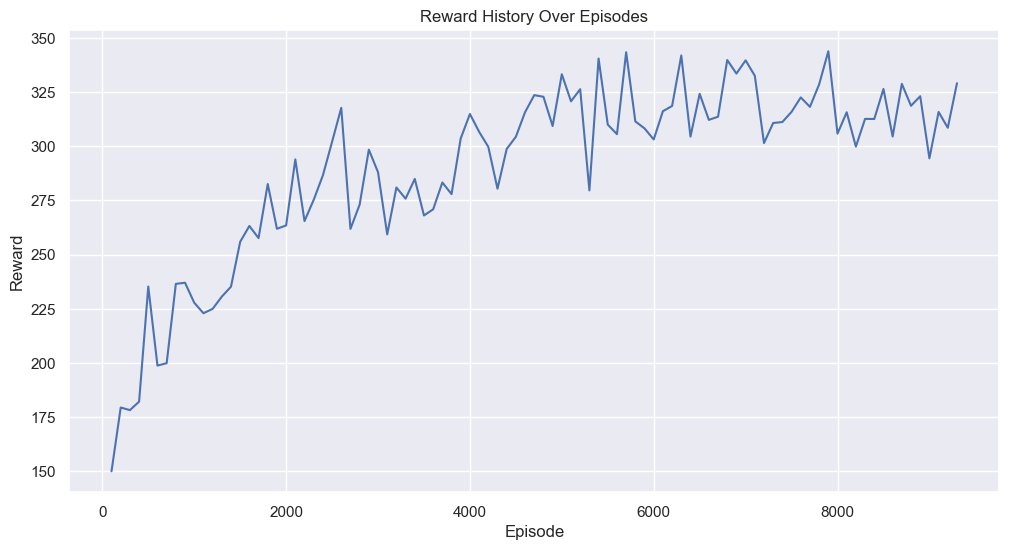

In [49]:
import seaborn as sns
plt.figure(figsize=(12,6))
sns.set(style="darkgrid")
sns.lineplot(x=rewards_mean['episode'],y=rewards_mean['mean_reward'])
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward History Over Episodes')
plt.show()